# Chapter 5: Electromechanical Dynamics | Small Disturbances

#### A quick introduction the simulation of a small disturbance, i.e. a short circuit in a simple 3 bus system

Still a work in progress, if there is anything missing or you have some general feedback please contact Sjur Føyen at foyen.sjur@ntnu.no 

Outline of notebook:
- Outline

Relevant Material from TET4180 Power System Stability and Control:
1. Slides (TET4180 Power System Stability and Control | Chapter 5: Electromechanical Dynamics – Small disturbances)
2. Power System Dynamics, Machowski   (Ch. 5.1: Swing equation | Ch. 5.3: Equilibrium points (synchronising power/torque) | Ch. 5.4: Steady state stability (Linear analysis) | Ch. 5.2: Damping power (torque) | Ch. 4.2.4.4: Rotor flux dynamics)
3. Assignment 4: Electromechanical dynamics - small disturbances


Code implemented by; Varg Førland. Date; 31.01.2025

Last update; 31.01.2025

GitHub Copilot used for assistance in coding.

In [1]:
%pip install git+https://github.com/hallvar-h/tops

import sys
from collections import defaultdict
import matplotlib.pyplot as plt
import time
import numpy as np

# Solver and dynamic models
from tops import dynamic as dps
from tops import solvers as dps_sol
#from tops.ps_models import ieee39

  Cloning https://github.com/hallvar-h/tops to /private/var/folders/8x/_s0cs76d26541h_f7wd81_n40000gn/T/pip-req-build-ufzruxh7
  Running command git clone --filter=blob:none --quiet https://github.com/hallvar-h/tops /private/var/folders/8x/_s0cs76d26541h_f7wd81_n40000gn/T/pip-req-build-ufzruxh7
  Resolved https://github.com/hallvar-h/tops to commit 2daedbf4daca07d8c1e644d433a3fb27896ffbb4
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Note: you may need to restart the kernel to use updated packages.


# Modeling the Power System

To effectively analyze the Power System it needs to be modeled, which is a balance act between retaining information while simplifying a complex system. First, we look at the swing equation and the relation between electrical and mechanical energy.

---

## The swing equation (chap. 5.1)

The **swing equation** is a fundamental equation in power systems that describes the dynamics of a synchronous machine's rotor. It represents the balance between the mechanical and electrical torques and how they affect the machine's angular position and speed.

- **Classic swing equation:**
    $$ J \frac{d^2\delta}{dt^2} + D_d \frac{d\delta}{dt} = \tau_m - \tau_e $$
    Where:
    - $ J $: Total moment of inertia
    - $ D_d $: Damping coefficient
    - $ \tau_m $: Mechanical torque
    - $ \tau_e $: Electromechanical torque
    - $ \delta $: Angle

This equation is derived from Newtons second law of motion as can be seen in the lecture slides. A particulary important relation which is utlized is the relation between rotational speed, or frequency, and the angle. The rotational speed can be expressed as 
$$
\omega_m = \omega_{sm} + \Delta \omega_m = \omega_{sm} + \frac{d\delta}{dt}
$$
where $\omega_sm$ is the synchronous speed, i.e. a constant $2 \pi \cdot 50Hz$. This also gives the relation 
$$
\frac{d\omega_m}{dt} = \frac{d^2\delta}{dt^2}
$$

#### Alternative expressions

The swing equation is commonly expressed in p.u. using power rather than torque, and inertia expressed in seconds. This version of the swing equation is expressed as

$$ 2 H \frac{d^2\delta}{dt^2} = P_m - P_e (\delta) - D_d \frac{d\delta}{dt} $$

---

## Equilibrium points (synchronising power/torque) (chap. 5.3)
Section 5.1 shows that the accelerating power depends on the difference between turbine power $P_m$ and electrical air-gap power $P_e$ (minus damping power $P_D$). Mechanical power is controlled by the turbine governor, while electrical air-gap power depends on generator loading, parameters, and power angle. In this section, we consider only the steady-state model of the generator-infinite busbar system, with the infinite busbar voltage $V_s$ as the reference.

In steady state, the generator is represented by a constant emf $E_q$ behind synchronous reactances $X_d$ and $X_q$. Neglecting resistances and shunt admittances, the air-gap power $P_e$ equals the power delivered to the system $P_s$ and is given by :
$$
P_e = P_{Eq} = \frac{E_q V_s}{x_d} \sin \delta + \frac{V_s^2}{2} (\frac{1}{x_q} - \frac{1}{x_d})  sin(2 \delta)
$$
in a salient pole generator. $x_d = X_d + X$, $x_q = X_q + X$, and $X = X_T + X_s$ is the combined reactance of the step-up transformer and equivalent network. The angle $\delta$ is the angle between $E_q$ and $V_s$ phasors (power angle) and the spatial angle between the generator rotor and the fictitious system generator (rotor angle). This links the swing equation with the electrical state of the generator. For constant $E_q$ and $V_s$, the power-angle characteristic $P_e = P_e(\delta)$ allows rewriting the swing equation.

If we have power with symmetry, for example in a round rotor generator where $x_d =x_d$, the expression simplifies to 
$$
P_e = P_{Eq} = \frac{E_q V_s}{x_d} \sin \delta
$$

Using these equations we can now consider the relationship between the power and power angle.


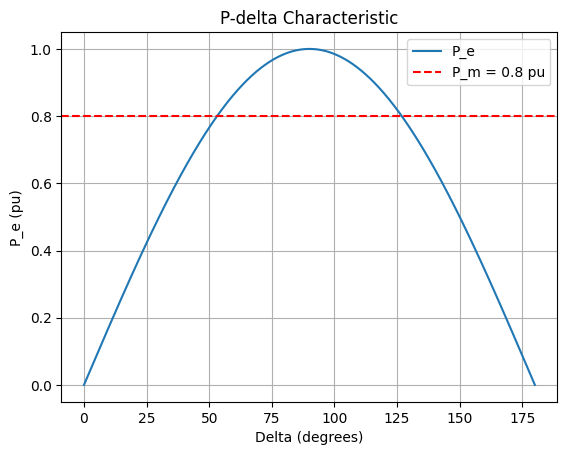

In [22]:
# Constants
P_m = 0.8  # Mechanical power in pu

x_d = 1.05  # D reactance
x_q = 1.05  # Q reactance
E_q_mag = 1.05  # Constant emf behind synchronous reactance
V_s = 1.0  # Infinite busbar voltage

# Delta values from 0 to pi
delta = np.linspace(0, np.pi, 1000)
delta_deg = np.degrees(delta)

# Power-angle characteristic
P_e = (E_q_mag * V_s / x_d) * np.sin(delta) + V_s ** 2 / 2 * (1/x_q - 1/x_d) * np.sin(2 * delta)

# Plotting
plt.figure()
plt.plot(delta_deg, P_e, label='P_e')
plt.xlabel('Delta (degrees)')
plt.ylabel('P_e (pu)')
plt.title('P-delta Characteristic')
plt.grid(True)
plt.axhline(y=P_m, color='r', linestyle='--', label='P_m = 0.8 pu')
plt.legend()
plt.show()


In [3]:
def load_assignment_model():
    return {
        'base_mva': 50, #'base_mva': system base/nominal complex power in [MVA].
        'f': 50, #'f': system frequency in [Hz].
        'slack_bus': 'B3', #'slack_bus': reference busbar with zero phase angle.

        'buses': [
            ['name',    'V_n'],
            ['B1',         10],
            ['B2',        245],
            ['B3',        245],
        ],
        #'V_n': base/nominal voltage in [kV].

        'lines': [
            ['name',  'from_bus', 'to_bus',   'length',   'S_n',  'V_n',  'unit', 'R',    'X',   'B'],
            ['L2-3',        'B2',     'B3',        250,      50,    245,    'PF',   0,    0.4,     0],
        ],
        #'length': total line length in [km].
        #'S_n': base/nominal complex power in [MVA].
        #'V_n': base/nominal voltage in [kV].
        #'unit': chosen unit for jacobian admittance calculation (leave it as 'PF').
        #'R': line resistance in [Ohm/km].
        #'X': line reactance in [Ohm/km].
        #'B': line susceptance in [Ohm/km].

        'transformers': [
            ['name', 'from_bus', 'to_bus', 'S_n', 'V_n_from', 'V_n_to', 'R', 'X'],
            ['T1',         'B1',     'B2',    50,         10,      245,   0, 0.1],
        ],
        #'S_n': base/nominal complex power in [MVA].
        #'V_n_from': base/nominal voltage on the 'from_bus' side in [kV].
        #'V_n_to': base/nominal voltage on the 'to_bus' side in [kV].
        #'R': transformer resistance in [pu].
        #'X': transformer reactance in [pu].

        'loads': [
            ['name', 'bus', 'P', 'Q', 'model'],
            ['L1',    'B2',  25,   0,     'Z'],
        ],
        #'P': active power delivered to the load in [MW].
        #'Q': reactive power delivered to the load in [MVAr].
        #'model': modelling of load voltage dependence (leave it as 'Z').

        'generators': {
            'GEN': [
                ['name',   'bus',  'S_n',  'V_n',    'P',    'V',      'H',    'D',    'X_d',  'X_q',  'X_d_t',    'X_q_t',    'X_d_st',   'X_q_st',   'T_d0_t',   'T_q0_t',   'T_d0_st',  'T_q0_st'],
                ['G1',      'B1',     50,     10,     40,  0.933,      3.1,      0,     1.05,   0.66,    0.328,      0.66,       0.254,      0.273,       2.49,      10000,         0.06,       0.15],
                ['IB',      'B3',    1e8,    245,    -15,  0.898,      1e5,      0,     1.05,   0.66,    0.328,      0.66,       0.254,      0.273,       2.49,      10000,         0.06,       0.15],
            ],
        },
        # For 'IB': change only 'V_n', 'P' and 'V' if necessary. Other parameters should be left as they are.

        # 'S_n': base/nominal complex power in [MVA].
        # 'V_n': base/nominal voltage in [kV].
        # 'P': active power produced by the generator in [MW].
        # 'V': magnitude of generator terminal voltage in [pu].
        # 'H': inertia constant in [MWs/MVA].
        # 'D': damping constant in [pu-power/pu-speed].
        # 'X_d'/'X_q': synchronous d-axis/q-axis reactance in [pu].
        # 'X_d_t'/'X_q_t': transient d-axis/q-axis reactance in [pu].
        # 'X_d_st'/'X_q_st': subtransient d-axis/q-axis reactance in [pu].
        # 'T_d0_t'/'T_q0_t': open-circuit d-axis/q-axis transient time constant in [s].
        # 'T_d0_st'/'T_q0_st': open-circuit d-axis/q-axis subtransient time constant in [s].
    }

0.12484519754133339
99%Simulation completed in 1.12 seconds.


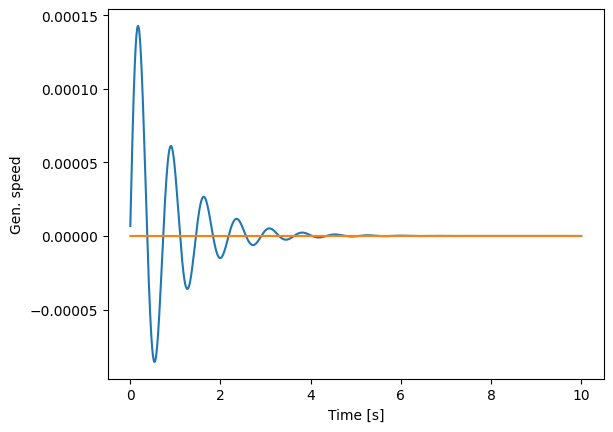

In [4]:
model = load_assignment_model()
# Power system model
ps = dps.PowerSystemModel(model=model)
ps.init_dyn_sim()
print(max(abs(ps.state_derivatives(0, ps.x_0, ps.v_0))))

t_end = 10
x_0 = ps.x_0.copy()

# Solver
sol = dps_sol.ModifiedEulerDAE(ps.state_derivatives, ps.solve_algebraic, 0, x_0, t_end, max_step=5e-3)

# Initialize simulation
t = 0
res = defaultdict(list)
t_0 = time.time()

sc_bus_idx = ps.gen['GEN'].bus_idx_red['terminal'][0]

# Run simulation
while t < t_end:
    sys.stdout.write("\r%d%%" % (t/(t_end)*100))

    ################  Assignment 3 / 4: Simulation of short-circuit  ################

    #if (...):
    #    ps.y_bus_red_mod[ , ] =
    #else:
    #    ps.y_bus_red_mod[ , ] =

    ##'y_bus_red_mod' refers to the fault admittance, the inverse of fault impedance.
    ##Fault: impedance = zero --> admittance = ?

    ##[0, 0]: corresponds to 'B1' (generator bus).
    ##[1, 1]: corresponds to 'B2' (load bus).
    ##[2, 2]: corresponds to 'B3' (stiff network).

    #################################################################################

    #####  Assignment 5/6: Short-circuit with line disconnection & reconnection #####

    #if (...) and (...):
    #   (...)
    #   ps.y_bus_red_mod[ , ] =

    #if (...) and (...):
    #    (...)
    #    ps.lines['Line'].event(ps, ps.lines['Line'].par['name'][0], 'disconnect')
    #    ps.y_bus_red_mod[ , ] =

    #if (...) and (...):
    #    (...)
    #    ps.lines['Line'].event(ps, ps.lines['Line'].par['name'][0], 'connect')

    #################################################################################

    # Simulate next step
    result = sol.step()
    x = sol.y
    v = sol.v
    t = sol.t

    dx = ps.ode_fun(0, ps.x_0)

    # Store result
    res['t'].append(t)
    res['gen_speed'].append(ps.gen['GEN'].speed(x, v).copy())

print('Simulation completed in {:.2f} seconds.'.format(time.time() - t_0))

plt.figure()
plt.plot(res['t'], res['gen_speed'])
plt.xlabel('Time [s]')
plt.ylabel('Gen. speed')
plt.show()